For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description. 
● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
● Discuss the resulting performance of the 2 chosen architectures. 

In [9]:
%pip install torch torch_geometric torch_scatter torch_sparse numpy pandas matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
try:
    from torch_geometric.nn import EdgeConv, global_mean_pool
    from torch_geometric.data import Data, DataLoader
except ImportError:
    print("PyTorch Geometric not installed. Installing now...")
    # Try to install PyTorch Geometric
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch-geometric"])
    # Try imports again
    from torch_geometric.nn import EdgeConv, global_mean_pool
    from torch_geometric.data import Data, DataLoader

In [5]:


def load_qg_dataset(data_dir='./data', use_bc=False, test_size=0.2, random_state=42):
    """
    Load QuarkGluon jet dataset from multiple .npz files, handling different particle counts
    """
    # Check if directory exists
    if not os.path.isdir(data_dir):
        raise FileNotFoundError(f"Data directory '{data_dir}' not found")
    
    print(f"Looking for .npz files in: {os.path.abspath(data_dir)}")
    all_files = [f for f in os.listdir(data_dir) if f.endswith('.npz')]
    
    # Filter files based on whether we want bc quarks
    if use_bc:
        data_files = [f for f in all_files if 'withbc' in f]
    else:
        data_files = [f for f in all_files if 'withbc' not in f]
    
    print(f"Selected {len(data_files)} files matching criteria (use_bc={use_bc})")
    
    all_jets = []
    all_labels = []
    max_particles = 0
    
    # First pass: determine maximum number of particles across all files
    for filename in data_files:
        filepath = os.path.join(data_dir, filename)
        try:
            data = np.load(filepath)
            X = data['X']
            max_particles = max(max_particles, X.shape[1])
            print(f"File {filename}: {X.shape[0]} jets, {X.shape[1]} max particles")
        except Exception as e:
            print(f"Error checking {filepath}: {e}")
    
    print(f"Maximum particles per jet across all files: {max_particles}")
    
    # Second pass: load and pad data to consistent size
    for filename in data_files:
        filepath = os.path.join(data_dir, filename)
        try:
            data = np.load(filepath)
            X = data['X']  # Shape: (n_jets, n_particles, 4)
            y = data['y']  # Shape: (n_jets,)
            
            # Pad jets to have the same maximum number of particles
            if X.shape[1] < max_particles:
                pad_width = ((0, 0), (0, max_particles - X.shape[1]), (0, 0))
                X_padded = np.pad(X, pad_width, mode='constant', constant_values=0)
            else:
                X_padded = X
                
            all_jets.append(X_padded)
            all_labels.append(y)
            
            print(f"Loaded {filepath}: {len(y)} jets, padded to {X_padded.shape[1]} particles")
            
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    
    if not all_jets:
        raise ValueError("No valid data files were loaded")
        
    # Combine data
    X_combined = np.concatenate(all_jets, axis=0)
    y_combined = np.concatenate(all_labels, axis=0)
    
    # Print dataset statistics
    n_quark = np.sum(y_combined == 1)
    n_gluon = np.sum(y_combined == 0)
    print(f"\nTotal jets: {X_combined.shape[0]} (Quark: {n_quark}, Gluon: {n_gluon})")
    print(f"Each jet has up to {X_combined.shape[1]} particles with {X_combined.shape[2]} features")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, test_size=test_size, 
        random_state=random_state, stratify=y_combined
    )
    
    print(f"Training set: {X_train.shape[0]} jets")
    print(f"Testing set: {X_test.shape[0]} jets")
    
    return X_train, X_test, y_train, y_test

data_dir = './QG_classification'  
X_train, X_test, y_train, y_test = load_qg_dataset(data_dir, use_bc=False)

# Print shapes
print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Calculate average number of non-zero particles per jet in training set
non_zero_particles = np.sum(np.sum(np.abs(X_train), axis=2) > 0, axis=1)
print(f"\nAverage non-zero particles per jet: {np.mean(non_zero_particles):.2f}")
print(f"Min particles: {np.min(non_zero_particles)}, Max particles: {np.max(non_zero_particles)}")


Looking for .npz files in: /Users/cassie/Documents/GSoC/QG_classification
Selected 20 files matching criteria (use_bc=False)
File QG_jets_13.npz: 100000 jets, 148 max particles
File QG_jets.npz: 100000 jets, 139 max particles
File QG_jets_12.npz: 100000 jets, 141 max particles
File QG_jets_10.npz: 100000 jets, 138 max particles
File QG_jets_11.npz: 100000 jets, 143 max particles
File QG_jets_8.npz: 100000 jets, 142 max particles
File QG_jets_15.npz: 100000 jets, 143 max particles
File QG_jets_14.npz: 100000 jets, 139 max particles
File QG_jets_9.npz: 100000 jets, 132 max particles
File QG_jets_16.npz: 100000 jets, 136 max particles
File QG_jets_17.npz: 100000 jets, 135 max particles
File QG_jets_7.npz: 100000 jets, 136 max particles
File QG_jets_6.npz: 100000 jets, 140 max particles
File QG_jets_4.npz: 100000 jets, 136 max particles
File QG_jets_19.npz: 100000 jets, 135 max particles
File QG_jets_18.npz: 100000 jets, 134 max particles
File QG_jets_5.npz: 100000 jets, 136 max particles


Using device: cpu
Using small dataset for testing: 500000 training jets, 100000 test jets
Converting jets to graphs...


/var/folders/61/z36hrmy516l8jpg81wnm8pr00000gn/T/ipykernel_40214/237809303.py:45: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor([y[i]], dtype=torch.long)
/Users/cassie/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/cassie/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Created 500000 training graphs and 100000 test graphs

Sample graph information:
Graph 0: 53 nodes, 2756 edges, Class: quark
Graph 1: 23 nodes, 506 edges, Class: quark
Graph 2: 46 nodes, 2070 edges, Class: gluon

Training with 450000 graphs, validating with 50000 graphs

Model architecture:
EdgeNetModel(
  (edge_nn1): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running

Epoch 1/20 [Val]: 100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


Epoch 1/20:
  Train Loss: 0.4781
  Val Loss: 0.4676, Val Acc: 0.7831, Val AUC: 0.8599
  New best model with AUC: 0.8599


Epoch 2/20 [Val]: 100%|██████████| 391/391 [01:26<00:00,  4.53it/s]


Epoch 2/20:
  Train Loss: 0.4663
  Val Loss: 0.4705, Val Acc: 0.7825, Val AUC: 0.8620
  New best model with AUC: 0.8620


Epoch 3/20 [Val]: 100%|██████████| 391/391 [01:17<00:00,  5.05it/s]


Epoch 3/20:
  Train Loss: 0.4632
  Val Loss: 0.4673, Val Acc: 0.7827, Val AUC: 0.8622
  New best model with AUC: 0.8622


Epoch 4/20 [Val]: 100%|██████████| 391/391 [01:17<00:00,  5.05it/s]


Epoch 4/20:
  Train Loss: 0.4618
  Val Loss: 0.4878, Val Acc: 0.7687, Val AUC: 0.8620


Epoch 5/20 [Val]: 100%|██████████| 391/391 [01:17<00:00,  5.05it/s]


Epoch 5/20:
  Train Loss: 0.4606
  Val Loss: 0.4578, Val Acc: 0.7891, Val AUC: 0.8655
  New best model with AUC: 0.8655


Epoch 6/20 [Val]: 100%|██████████| 391/391 [01:17<00:00,  5.06it/s]


Epoch 6/20:
  Train Loss: 0.4599
  Val Loss: 0.4577, Val Acc: 0.7896, Val AUC: 0.8648


Epoch 7/20 [Val]: 100%|██████████| 391/391 [01:20<00:00,  4.89it/s]


Epoch 7/20:
  Train Loss: 0.4595
  Val Loss: 0.4571, Val Acc: 0.7898, Val AUC: 0.8651


Epoch 8/20 [Val]: 100%|██████████| 391/391 [01:16<00:00,  5.11it/s]


Epoch 8/20:
  Train Loss: 0.4586
  Val Loss: 0.4561, Val Acc: 0.7897, Val AUC: 0.8662
  New best model with AUC: 0.8662


Epoch 9/20 [Val]: 100%|██████████| 391/391 [01:16<00:00,  5.14it/s]


Epoch 9/20:
  Train Loss: 0.4583
  Val Loss: 0.4554, Val Acc: 0.7912, Val AUC: 0.8662
  New best model with AUC: 0.8662


Epoch 10/20 [Val]: 100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


Epoch 10/20:
  Train Loss: 0.4578
  Val Loss: 0.4774, Val Acc: 0.7773, Val AUC: 0.8631


Epoch 11/20 [Val]: 100%|██████████| 391/391 [01:15<00:00,  5.16it/s]


Epoch 11/20:
  Train Loss: 0.4579
  Val Loss: 0.4625, Val Acc: 0.7872, Val AUC: 0.8652


Epoch 12/20 [Val]: 100%|██████████| 391/391 [01:16<00:00,  5.13it/s]


Epoch 12/20:
  Train Loss: 0.4573
  Val Loss: 0.4600, Val Acc: 0.7890, Val AUC: 0.8655


Epoch 13/20 [Val]: 100%|██████████| 391/391 [01:15<00:00,  5.19it/s]


Epoch 13/20:
  Train Loss: 0.4549
  Val Loss: 0.4523, Val Acc: 0.7924, Val AUC: 0.8684
  New best model with AUC: 0.8684


Epoch 14/20 [Val]: 100%|██████████| 391/391 [01:26<00:00,  4.54it/s]


Epoch 14/20:
  Train Loss: 0.4543
  Val Loss: 0.4535, Val Acc: 0.7922, Val AUC: 0.8681


Epoch 15/20 [Val]: 100%|██████████| 391/391 [01:28<00:00,  4.42it/s]


Epoch 15/20:
  Train Loss: 0.4543
  Val Loss: 0.4521, Val Acc: 0.7927, Val AUC: 0.8683


Epoch 16/20 [Val]: 100%|██████████| 391/391 [01:28<00:00,  4.40it/s]


Epoch 16/20:
  Train Loss: 0.4536
  Val Loss: 0.4523, Val Acc: 0.7924, Val AUC: 0.8689
  New best model with AUC: 0.8689


Epoch 17/20 [Val]: 100%|██████████| 391/391 [01:24<00:00,  4.63it/s]


Epoch 17/20:
  Train Loss: 0.4537
  Val Loss: 0.4520, Val Acc: 0.7931, Val AUC: 0.8684


Epoch 18/20 [Val]: 100%|██████████| 391/391 [01:33<00:00,  4.19it/s]


Epoch 18/20:
  Train Loss: 0.4537
  Val Loss: 0.4560, Val Acc: 0.7909, Val AUC: 0.8691
  New best model with AUC: 0.8691


Epoch 19/20 [Val]: 100%|██████████| 391/391 [01:33<00:00,  4.19it/s]


Epoch 19/20:
  Train Loss: 0.4534
  Val Loss: 0.4527, Val Acc: 0.7928, Val AUC: 0.8686


Epoch 20/20 [Val]: 100%|██████████| 391/391 [01:27<00:00,  4.45it/s]


Epoch 20/20:
  Train Loss: 0.4530
  Val Loss: 0.4508, Val Acc: 0.7946, Val AUC: 0.8692
  New best model with AUC: 0.8692


Testing: 100%|██████████| 782/782 [02:59<00:00,  4.35it/s]



Test Results:
  Accuracy: 0.7967
  AUC: 0.8710
  Confusion Matrix:
    TN: 41501, FP: 8497
    FN: 11828, TP: 38174


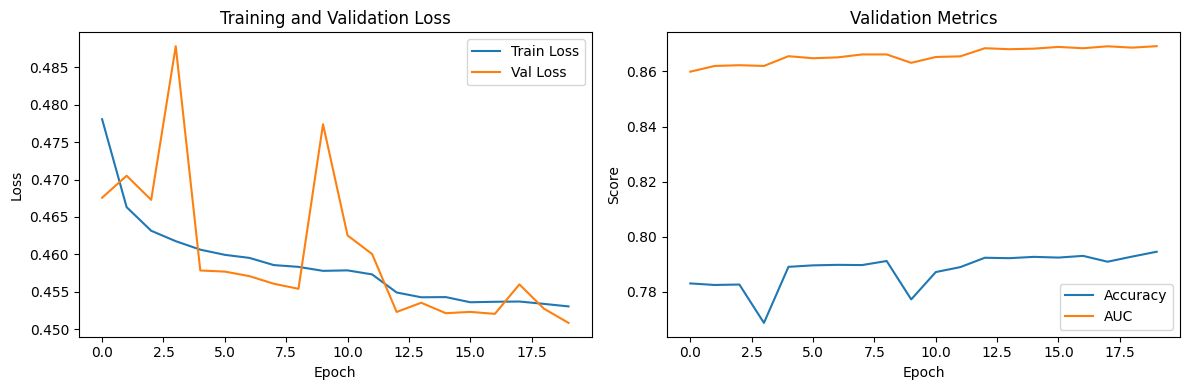

Model saved to 'qg_gnn_model.pt'


In [8]:

# Convert jet data to graph structures
def jets_to_graphs(X, y, threshold=1e-5):
    '''
    Parameters:
    X : numpy.ndarray
        Jet data of shape (n_jets, n_particles, n_features)
    y : numpy.ndarray
        Jet labels (0 for gluon, 1 for quark)
    threshold : float
        Threshold to filter out zero-padded particles and noise
    
    Returns:
    list of torch_geometric.data.Data
        List of graph objects
    '''
    graph_list = []

    for i in range(len(X)):
        # Extract non-zero particle data and filtering out very low-energy particles that are probably detector noise
        mask = np.sum(np.abs(X[i]), axis=1) > threshold
        particles = X[i][mask]

        if len(particles) == 0:
            continue
            
        # Use pt, eta, phi as node features
        node_features = torch.tensor(particles[:, :4], dtype=torch.float)
        
        # Edge indices: fully connected graph
        n_particles = len(particles)
        if n_particles > 1:
            edge_index = []
            for j in range(n_particles):
                for k in range(n_particles):
                    if j != k:
                        edge_index.append([j, k])  # avoid self-loops
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.tensor([[0], [0]], dtype=torch.long)
            
        # Create the graph object
        graph = Data(
            x=node_features, 
            edge_index=edge_index, 
            y=torch.tensor([y[i]], dtype=torch.long)
        )
        graph_list.append(graph)
    return graph_list
                        
# Define the graph convolutional neural network
class EdgeNetModel(torch.nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32):
        super(EdgeNetModel, self).__init__()
        # Network that computes pairwise edge features
        self.edge_nn1 = nn.Sequential(
            nn.Linear(2*input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        # First edge convolution layer
        self.conv1 = EdgeConv(self.edge_nn1, aggr='max')
        
        # Second edge convolution block
        self.edge_nn2 = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        self.conv2 = EdgeConv(self.edge_nn2, aggr='max')
        
        # Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 2)  # Binary classification: quark or gluon
        )
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # If batch is None, set it to zeros
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # Apply graph convolutional layers
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Classification
        return self.mlp(x)
    
# Train the model and evaluation utilities
def train_model(model, train_loader, val_loader, device, epochs=20, lr=0.001):
    model = model.to(device)  # Fixed: Changed model_to to model.to
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accs = []
    val_aucs = []

    best_val_auc = 0
    best_model_state = None

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for data in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs

        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0  
        predictions = []
        true_labels = []
        probabilities = []

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data.y)
                val_loss += loss.item() * data.num_graphs
                
                pred = output.argmax(dim=1)
                prob = F.softmax(output, dim=1)[:, 1]  # Probability of being class 1 (quark)
                
                predictions.extend(pred.cpu().numpy())
                true_labels.extend(data.y.cpu().numpy())
                probabilities.extend(prob.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_acc = accuracy_score(true_labels, predictions)
        val_auc = roc_auc_score(true_labels, probabilities)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
        
        # Update learning rate
        scheduler.step(val_auc)
        
        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict().copy()
            print(f"  New best model with AUC: {val_auc:.4f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_aucs': val_aucs,
        'best_val_auc': best_val_auc
    }

# Put it all together
def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    
    # Create a small subset for quick testing
    test_size = 500000  
    
    # Take a small subset of the data
    indices_train = np.random.choice(len(X_train), test_size, replace=False)
    indices_test = np.random.choice(len(X_test), test_size//5, replace=False)
    
    X_train_small = X_train[indices_train]
    y_train_small = y_train[indices_train]
    X_test_small = X_test[indices_test]
    y_test_small = y_test[indices_test]
    
    print(f"Using small dataset for testing: {len(X_train_small)} training jets, {len(X_test_small)} test jets")
    
    # Convert the data to graphs
    print("Converting jets to graphs...")
    train_graphs = jets_to_graphs(X_train_small, y_train_small)
    test_graphs = jets_to_graphs(X_test_small, y_test_small)
    print(f"Created {len(train_graphs)} training graphs and {len(test_graphs)} test graphs")
    
    # Sample a few graphs for inspection
    print("\nSample graph information:")
    for i in range(min(3, len(train_graphs))):
        g = train_graphs[i]
        print(f"Graph {i}: {g.num_nodes} nodes, {g.num_edges} edges, "
              f"Class: {'quark' if g.y.item() == 1 else 'gluon'}")
    
    # Create DataLoaders
    batch_size = 128
    
    # Split train set for validation
    n_val = int(0.1 * len(train_graphs))
    val_graphs = train_graphs[:n_val]
    train_graphs = train_graphs[n_val:]
    
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=batch_size)
    test_loader = DataLoader(test_graphs, batch_size=batch_size)
    
    print(f"\nTraining with {len(train_graphs)} graphs, validating with {len(val_graphs)} graphs")
    
    # Initialize and train the model
    model = EdgeNetModel(input_dim=4, hidden_dim=64)
    print(f"\nModel architecture:\n{model}")
    
    # Train the model
    model, history = train_model(
        model, train_loader, val_loader, device, 
        epochs=20, lr=0.001
    )
    
    # Evaluate on test set
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            prob = F.softmax(output, dim=1)[:, 1]
            
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(data.y.cpu().numpy())
            probabilities.extend(prob.cpu().numpy())
    
    # Calculate test metrics
    test_acc = accuracy_score(true_labels, predictions)
    test_auc = roc_auc_score(true_labels, probabilities)
    
    print("\nTest Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  AUC: {test_auc:.4f}")
    
    cm = confusion_matrix(true_labels, predictions)
    print(f"  Confusion Matrix:")
    print(f"    TN: {cm[0, 0]}, FP: {cm[0, 1]}")
    print(f"    FN: {cm[1, 0]}, TP: {cm[1, 1]}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accs'], label='Accuracy')
    plt.plot(history['val_aucs'], label='AUC')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('gnn_training_history.png')
    plt.show()
    
    # Save the model
    torch.save(model.state_dict(), 'qg_gnn_model.pt')
    print("Model saved to 'qg_gnn_model.pt'")
    
    return model, history, (test_acc, test_auc)

# Execute the main function
if __name__ == '__main__':
    model, history, (test_acc, test_auc) = main()

Performance Metrics:
Test Accuracy: 79.67% 
Test AUC: 0.8710 
Validation AUC: 0.8692 - close match between validation and test AUC (0.8692 vs 0.8710) shows good generalization
Training Dynamics
Smooth convergence - Training loss steadily decreased from 0.4781 to 0.4530
Consistent improvement - Best model updates occurred throughout training (epochs 1, 2, 3, 5, 8, 9, 13, 16, 18, 20)
No overfitting - The gap between training and validation loss remained small, indicating good regularization
Steady gains - Performance was still slightly improving at epoch 20, suggesting more epochs might yield additional small gains

Confusion Matrix Analysis:
TN: 41,501  FP: 8,497
FN: 11,828  TP: 38,174
Gluon identification (TN): 41,501/(41,501+8,497) = 83.0% correct
Quark identification (TP): 38,174/(38,174+11,828) = 76.3% correct